# Curve v2 newton method

The comparison of newton‘s method implementations.

In [57]:
from functools import reduce
import pandas as pd

In [58]:
n = 2

MAX_TIMES = 255
A_MULTIPLIER = 10000


In [59]:
def geometric_mean(x):
    N = len(x)
    x = sorted(x, reverse=True)  # Presort - good for convergence
    D = x[0]
    for i in range(255):
        D_prev = D
        tmp = 10 ** 18
        for _x in x:
            tmp = tmp * _x // D
        D = D * ((N - 1) * 10**18 + tmp) // (N * 10**18)
        diff = abs(D - D_prev)
        if diff <= 1 or diff * 10**18 < D:
            return D
    raise ValueError("Did not converge")

In [60]:
def D_math(A, gamma, x, D0, target_value=0):
    '''calculate theoretical value by newton method without optimized.'''
    D = D0
    A //= A_MULTIPLIER

    S = sum(x)
    x = sorted(x, reverse=True)
    N = len(x)
    times = 0

    losses = []

    for i in range(255):
        D_prev = D

        K0 = 10**18
        prod = 1  # 36
        D_N = 1 # 36
        for _x in x:
            K0 = K0 * _x * N // D
            prod *= _x
            D_N *= D // N

        g1k0 = abs(gamma + 10**18 - K0) # 18

        # D = D - f/f'
        numerator = D*g1k0*D_N*(D*prod*(g1k0**2 - A*gamma**2) - D*g1k0**2*D_N + A*prod*gamma**2*S)
        denominator = D*N*(10**18*(-2)*A*prod**2*gamma**2 + g1k0**3*D_N**2) + A*prod*gamma**2*(10**18*2*N*prod + g1k0*D_N)*S

        D = (D * denominator + numerator) // denominator

        times += 1

        if target_value > 0:
            losses.append(abs(D - target_value))

        if D < 0:
            print("math neg D", D)
            D = -D // 2

        if abs(D - D_prev) <= max(100, D // 10**14):
            # print("math times {} D {:.0f}".format(times, D))
            return D, losses

    raise ValueError("Did not converge")



In [61]:
def D_curve(A, gamma, x, D0, target_value=0):
    D = D0

    S = sum(x)
    x = sorted(x, reverse=True)
    N = len(x)
    
    losses = []

    for i in range(255):
        D_prev = D

        K0 = 10**18
        for _x in x:
            K0 = K0 * _x * N // D

        _g1k0 = abs(gamma + 10**18 - K0)

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1 = 10**18 * D // gamma * _g1k0 // gamma * _g1k0 * A_MULTIPLIER // A

        # 2*N*K0 / _g1k0
        mul2 = (2 * 10**18) * N * K0 // _g1k0

        neg_fprime = (S + S * mul2 // 10**18) + mul1 * N // K0 - mul2 * D // 10**18
        assert neg_fprime > 0  # Python only: -f' > 0

        # D -= f / fprime
        D = (D * neg_fprime + D * S - D**2) // neg_fprime - D * (mul1 // neg_fprime) // 10**18 * (10**18 - K0) // K0

        if target_value > 0:
            losses.append(abs(D - target_value))

        if D < 0:
            D = -D // 2
        if abs(D - D_prev) <= max(100, D // 10**14):
            return D, losses

    raise ValueError("Did not converge")


def process_newton_D(A, gamma, xp, D0, target_value):
    return D_curve(A, gamma, xp, D0, target_value), D_math(A, gamma, xp, D0, target_value)


In [62]:
def compare(A_list, xp_list):
    '''compare different newton‘s method implementations'''

    data = []
    losses = []

    for A in A_list:
        for xp in xp_list:
            xp_decimals = [xp*10**18 for xp in xp]

            ANN = A*n**n*A_MULTIPLIER
            gamma = int(7e-5 * 1e18)
            D0 = len(xp) * geometric_mean(xp_decimals)

            d_math, _ = D_math(ANN, gamma, xp_decimals, D0)
            # print(d_math)
            (d_curve, d_curve_losses), (d_math, d_math_losses) = process_newton_D(ANN, gamma, xp_decimals, D0, int(d_math))
            curve_loss = abs(d_curve - d_math)

            data.append([A, "{:.2f}".format(xp[0]), "{:.2f}".format(xp[1]),
                        d_curve, len(d_curve_losses), curve_loss,
                        d_math, len(d_math_losses),
                        ])

            losses.append([d_curve_losses, d_math_losses])

    # loss: loss ratia * 1e18
    df = pd.DataFrame(data, columns=[
                      'A', 'x', 'y', 'd_curve', 'times', 'loss', 'd_math', 'times',
                      ])
    return df, losses


In [63]:
'''
print results
'''
pd.set_option('display.width', 5000)
pd.set_option('display.float_format', lambda x: '%d' % x)

A_list = [10, 100]
xp_list = [[1, 99], [10, 90], [40, 60], [49, 51]]

comparison, losses = compare(A_list, xp_list)
print(comparison)


     A      x      y               d_curve  times  loss                d_math  times
0   10   1.00  99.00  19991396570029611703     17     3  19991396570029611700     17
1   10  10.00  90.00  60150830502292263405     16     0  60150830502292263405     16
2   10  40.00  60.00  98054407597527121193     13    18  98054407597527121211     13
3   10  49.00  51.00  99990857820356012509      9    30  99990857820356012539      9
4  100   1.00  99.00  20098171791222724321     19     4  20098171791222724325     19
5  100  10.00  90.00  60326559389246477229     18    11  60326559389246477240     18
6  100  40.00  60.00  98140962103923912109     15    23  98140962103923912132     15
7  100  49.00  51.00  99997056665062035359     11     8  99997056665062035367     11


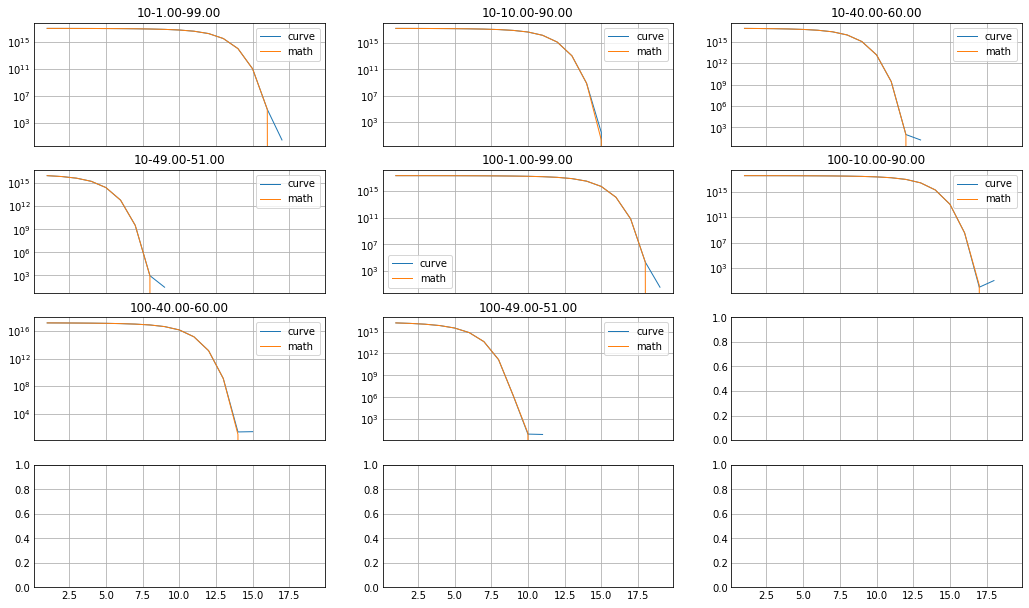

In [64]:
import matplotlib.pyplot as plt

plt.style.use('_mpl-gallery')


# plot
n_rows = 4
n_cols = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True,
                        figsize=(14, 8))
# fig.suptitle("newton's method loss comparision")


def draw_loss(ax_index, curve_losses, math_losses):
    _ax = axs[ax_index // n_cols][ax_index % n_cols]

    x_max = max(len(curve_losses), len(math_losses))
    x = [i+1 for i in range(x_max)]  # axis-x is loop times

    y0 = []
    y1 = []
    for j in range(x_max):
        if j < len(curve_losses):
            y0.append(curve_losses[j])
        else:
            y0.append(None)
        if j < len(math_losses):
            y1.append(math_losses[j])
        else:
            y1.append(None)

    l = comparison.loc[ax_index]
    _ax.set_yscale('log')
    _ax.plot(x, y0, linewidth=1.0, label="curve")
    _ax.plot(x, y1, linewidth=1.0, label="math")
    _ax.set_title("{}-{}-{}".format(l['A'], l['x'], l['y']))
    _ax.legend(loc='best')


for i in range(len(losses)):
    draw_loss(i, losses[i][0], losses[i][1])


plt.show()
